Sampling rate: 12500 Hz
Duration of 256 samples: 20.48 milliseconds



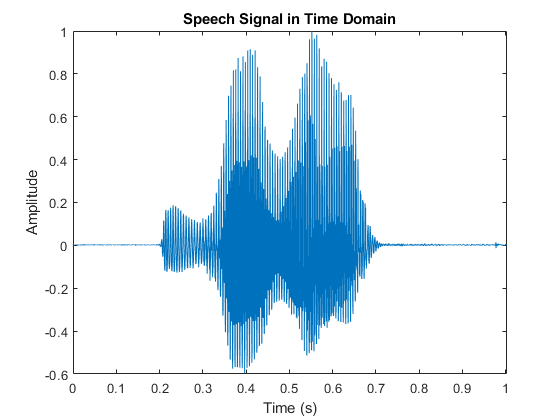

In [2]:
[y, Fs] = audioread('GivenSpeech_Data/Test_Data/s1.wav');
sound(y, Fs);

% Normalize
y = y / max(abs(y));

% Calculate time for 256 samples 
time_ms = (256 / Fs) * 1000;
fprintf('Sampling rate: %d Hz\n', Fs);
fprintf('Duration of 256 samples: %.2f milliseconds\n', time_ms);

% Plot signal in time domain
t = (0:length(y)-1) / Fs;  
figure;
plot(t, y);
xlim([0 max(t)]);
xlabel('Time (s)');
ylabel('Amplitude');
title('Speech Signal in Time Domain');

Frame size N=512: Maximum energy at 355.68 ms and 366.21 Hz



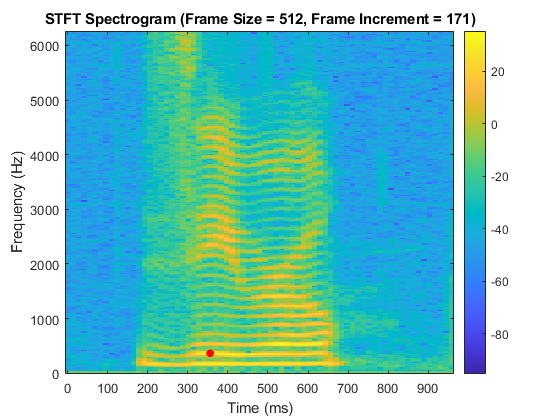

In [3]:
N = 512;  % Frame size
M = round(N/3); % frame increment

num_frames = floor((length(y) - N) / M) + 1;
stft_result = zeros(N, num_frames);
window = hamming(N);

% Compute STFT
for i = 1:num_frames
    frame_start = (i-1)*M + 1;
    frame = y(frame_start:frame_start+N-1) .* window;
    stft_result(:,i) = abs(fft(frame));
end

stft_result = stft_result(1:N/2+1, :);
stft_result_db = 20*log10(stft_result);

% Create time and frequency vectors for plotting
t = ((0:num_frames-1) * M) / Fs * 1000;  % Time in milliseconds
f = (0:N/2) * Fs / N;  % Frequency in Hz

% Plot spectrogram
figure;
imagesc(t, f, stft_result_db);
axis xy;  % Put low frequencies at bottom
colorbar;
xlabel('Time (ms)');
ylabel('Frequency (Hz)');
title(sprintf('STFT Spectrogram (Frame Size = %d, Frame Increment = %d)', N, M));

% Find region with most energy
[max_energy_val, max_idx] = max(stft_result_db(:));
[freq_idx, time_idx] = ind2sub(size(stft_result_db), max_idx);
max_energy_time = t(time_idx);
max_energy_freq = f(freq_idx);

fprintf('Frame size N=%d: Maximum energy at %.2f ms and %.2f Hz\n', ...
        N, max_energy_time, max_energy_freq);

% Optional: Mark the maximum energy point
hold on;
plot(max_energy_time, max_energy_freq, 'r.', 'MarkerSize', 20);
hold off;

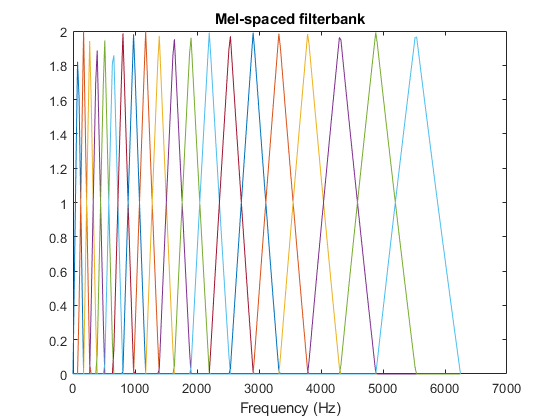

In [4]:
mel_filter = melfb(20, N, Fs);

plot(linspace(0, (Fs/2), N/2+1), melfb(20, 512, 12500)');
title('Mel-spaced filterbank'), xlabel('Frequency (Hz)');

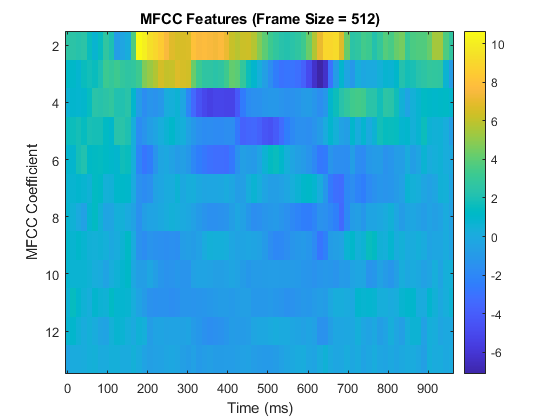

In [5]:
% Parameters for melfb
num_mel_filters = 20;
mfcc_coeff = 13;

% Initialize MFCC matrix
mfcc_features = zeros(mfcc_coeff-1, num_frames);

% Get mel filterbank
mel_filters = melfb(num_mel_filters, N, Fs);

% Compute MFCC for each frame
for i = 1:num_frames
    frame_start = (i-1)*M + 1;
    frame = y(frame_start:frame_start+N-1) .* window;
    
    % Power spectrum
    power_spectrum = abs(fft(frame)).^2;
    power_spectrum = power_spectrum(1:N/2+1);
    
    % Apply mel filterbank
    mel_energies = mel_filters * power_spectrum;
    
    % Apply DCT to get MFCC
    mfcc = dct(log(mel_energies(1:mfcc_coeff)));
    
    % Keep only the specified number of coefficients
    mfcc_features(:, i) = mfcc(2:end);
end

% Create time vector for plotting
t = ((0:num_frames-1) * M) / Fs * 1000;  % Time in milliseconds
    
% Plot MFCC features
figure;
imagesc(t, 2:mfcc_coeff, mfcc_features);
colorbar;
xlabel('Time (ms)');
ylabel('MFCC Coefficient');
title(sprintf('MFCC Features (Frame Size = %d)', N));
